In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd
from tqdm.notebook import tqdm
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel
from sklearn.datasets import make_blobs

import sys
sys.path.append("../../")

import tetrahedron
import proj_quality
from metric.metric import Metric, Euclid, Triangular

In [11]:
# simulate triangles
metric = Euclid(2)
DEFAULT_SAMPLE_SIZE = 300

def skew(points):
    """stretch each axis by a random factor"""
    scale = 1 + 10* rng.random(size=points.shape[-1])
    return points * scale[np.newaxis, :]

def generate_univar_points(rng, n_samples = DEFAULT_SAMPLE_SIZE, dim = 7, homogenious=True):
    points = rng.random(size=[n_samples, dim]) * 37 - 37/2
    if not homogenious:
        points = skew(points)
    return points

def generate_univar_grid_points(rng, n_samples = DEFAULT_SAMPLE_SIZE, dim = 7):
    points = rng.integers(low=37//2, high=37*2, size=[n_samples, dim])
    return points

def generate_gaussian_points(rng, n_samples = DEFAULT_SAMPLE_SIZE, dim = 7, homogenious=False):
    points = rng.standard_normal([n_samples, dim])
    if not homogenious:
        points = skew(points)
    return points

def generate_multi_cluster(rng, n_samples=DEFAULT_SAMPLE_SIZE, dim=7):
    std = 3 # good overlap, but still differentiable
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std,
                random_state=rng.integers(np.iinfo("int32").max))
    return points

def generate_sparse_cluster(rng, n_samples=DEFAULT_SAMPLE_SIZE, dim=7):
    std = 1 # almost no overlap
    points, labels = make_blobs(n_samples=n_samples, 
                  n_features=dim, 
                  centers=4, 
                  cluster_std=std,
                  random_state=rng.integers(np.iinfo("int32").max))
    return points

generators = {
    "univariate, idd":lambda **kwargs:generate_univar_points(**kwargs, homogenious=False),
    "univariate, stretched":lambda **kwargs:generate_univar_points(**kwargs, homogenious=False),
    "gaussian, circular":lambda **kwargs:generate_gaussian_points(**kwargs, homogenious=True),
    "gaussian, eliptic":lambda  **kwargs:generate_gaussian_points(**kwargs, homogenious=False),
    "clusters, overlapping":generate_multi_cluster,
    "clusters, sparse":generate_sparse_cluster
}

In [12]:
def _hilbert_quality(points, r):
    try:
        part = proj_quality.HilbertPartitioner(points, r)
        return part.hyperplane_quality(points)
    except KeyError:
        raise
        return 0

def optimize_pivots(points, criterion, return_full=False):
    quality = np.nan * np.ones([len(points), len(points)],float)

    for i, p0 in enumerate(tqdm(points)):
        for j, p1 in enumerate(points):
            if j<=i: continue
            try:
                points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                quality[i,j] = criterion(points_p)
            except:
                quality[i,j] = np.nan

    
    # make symmetric
    lower_tri = np.tril_indices(quality.shape[0], -1)
    quality[lower_tri] = quality.T[lower_tri]
    
    quality = mask_diag(quality)
    
    if return_full:    
        return quality
    else:
        return np.array(np.unravel_index(np.argmax(quality), quality.shape))

def hilbert_optimal_pivots(ps, rng):
    r = proj_quality.get_average_k_nn_dist(ps, metric, k=10)
    pivots_idx = optimize_pivots(ps, lambda x:_hilbert_quality(x, r), False)
    return ps[pivots_idx]


def optimize_pivot(points, p0, criterion, rng=None):
    quality = []
    r = proj_quality.get_average_k_nn_dist(points, metric, k=10)
    for p1 in points:
        try:
            points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
            quality.append(criterion(points_p, r))
        except KeyError:
            quality.append(0)
        except AssertionError:
            quality.append(0)
    return points[np.argmax(quality)]

def hilbert_almost_optimal(ps, rng=None):
    p0,_ = two_least_central(ps)
    p1 = optimize_pivot(ps, p0, _hilbert_quality)
    return p0, p1

In [13]:
def mask_diag(a):
    diag = np.diag(np.ones(a.shape[0]))
    return np.ma.array(a, mask=diag)

def max_dist_points(ps, rng=None):
    dists = metric.distance_matrix(ps,ps)
    flat_index = dists.argmax()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

def min_dist_points(ps, rng=None):
    dists = metric.distance_matrix(ps,ps)
    diag = np.diag_indices(len(ps))
    dists[diag] = np.inf
    
    flat_index = dists.argmin()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

def get_most_central_points_idx(ps, rng=None):
    dists = metric.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    
    return np.argsort(dists.std(axis=1))

def two_most_central(ps, rng=None):
    cent = get_most_central_points_idx(ps)
    return ps[cent[:2]]

def two_least_central_heuristically(ps, rng:np.random.Generator, budget = np.sqrt):
    """
    Find the two pivots that approximately maximize `Var[d(piv, .)]`.

    ps: points in the space
    budget: limit to O(n*budget(n)) distance method calls.
            Default: O(n^1.5)
    """
    dist_budget = len(ps) * int(budget(len(ps)))

    # instead of implementing this, simulate this by throwing away entries
    # from a full distance matrix
    dists = metric.distance_matrix(ps,ps)

    
    diag_elements = len(dists)
    # dists is symmetric, so each value has a partner
    dist_evaluations = (dists.size - diag_elements)//2
    count_discards = dist_evaluations - dist_budget
    discard = rng.choice(range(dist_evaluations), replace=False, size=count_discards)

    # lower triangle matrix with the diagonal excluded
    keep = np.tri(len(dists), k=-1, dtype=bool)
    discard_pairs = np.argwhere(keep == 1)[discard]
    discard_idx = discard_pairs.T
    keep[*discard_idx] = False
    dists[~keep] = -1
    
    actual_evaluations = dists.size - (dists == -1).sum()
    assert np.allclose(actual_evaluations, dist_budget, atol=2), f"`dists` has {actual_evaluations:e} entries, but it should have no more than {dist_budget:e}!"

    # make matrix symmetric again
    dists = np.maximum(dists, dists.T)
    assert np.allclose(dists, dists.T)

    dists = np.ma.array(dists, mask=dists==-1)
    centricity = np.argsort(dists.std(axis=1))

    # the two pivots with the highest std might be close together
    p0 = ps[centricity[-1]]
    p1 = _choose_reasonably_remote_partner(ps[centricity], p0)
    
    return p0, p1

def _choose_reasonably_remote_partner(ps, p0):
    """Return the last a partner in the list for `p0` that is farther away than the average distance.
    """
    dists = metric(p0, ps)
    cutoff = dists.mean()
    p1 = ps[dists > cutoff][-1]
    return p1

def two_least_central(ps, rng=None):
    cent = get_most_central_points_idx(ps)
    return ps[cent[-2:]]

def low_centrality_and_far_away(ps, rng=None):
    cent = get_most_central_points_idx(ps)
    p0 = ps[cent[-1]]
    p1 = _choose_reasonably_remote_partner(ps[cent], p0)
    return p0, p1

def two_remote_points(ps, rng=None):
    dists = metric.distance_matrix(ps,ps)
    dists = mask_diag(dists)
    remoteness = (dists**2).sum(axis=1)
    remoteness_idx = np.argsort(remoteness)
    return ps[remoteness_idx[-2:]]

def central_and_distant(ps, rng=None):
    cent = get_most_central_points_idx(ps)
    p0 = ps[cent[0]]
    most_dist = np.argmax(metric(p0, ps))
    p1 = ps[most_dist]
    return p0, p1

def find_close_center(ps, cluster_member, rng=None):
    dists = metric(cluster_member, ps)
    close_points = ps[dists < np.median(dists)]
    
    dists = metric.distance_matrix(close_points, close_points)
    dists = mask_diag(dists)
    
    center_idx = np.argmin(dists.std(axis=1))
    return close_points[center_idx]

def different_cluster_centers(ps, rng=None):
    # a,b are likely in different clusters
    a, b = max_dist_points(ps)
    center_a = find_close_center(ps, a)
    center_b = find_close_center(ps, b)

    while np.allclose(center_a, center_b):
        # we need two distinct pivots!
        center_b = rng.choice(ps, size=1) 
    return center_a, center_b

def random_pivots(ps, rng=None):
    return rng.choice(ps, size=2, replace=False)

algs = dict(
    random=random_pivots,
    maximize_dist=max_dist_points,
    # those two always perform worse 
    #minimize_dist=min_dist_points,
    #central_points=two_most_central,
    non_central_points=two_least_central,
    non_central_points_approx=two_least_central_heuristically,
    remoteness=two_remote_points,
    central_and_distant=central_and_distant,
    different_cluster_centers=different_cluster_centers,
    almost_optimized_hq=hilbert_almost_optimal,
    optimized_hq=hilbert_optimal_pivots
)

  0%|          | 0/100 [00:00<?, ?it/s]

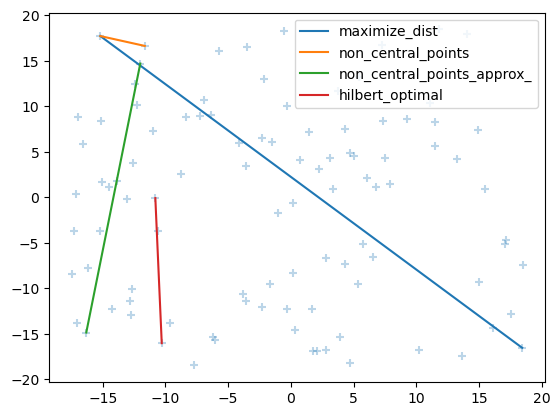

In [14]:
rng = np.random.default_rng()
points = generate_univar_points(rng, dim=2, n_samples=100)

test_algs = dict(
    maximize_dist=max_dist_points,
    non_central_points=two_least_central,
    non_central_points_approx_=two_least_central_heuristically,
    hilbert_optimal=hilbert_optimal_pivots,
    )

plt.scatter(points[:,0], points[:,1], alpha=0.3, marker="+")

for name, piv_func in test_algs.items():
    exact = np.array(piv_func(points, rng=rng))
    plt.plot(exact[:,0], exact[:,1], label=name)
    

plt.legend()
# TODO: Choose two opposite non-central points!

In [15]:
def compare_projections(point_gen:dict, pivot_selector:dict, dims:list, seed=0, errors="skip"):
    rv = []
    rng = np.random.default_rng(seed)
    for dim in dims:
        for gen_name, gen_func in point_gen.items():
            points = gen_func(dim=dim, rng=rng)
            r = proj_quality.get_average_k_nn_dist(points, metric, k=10)
            for algo_name, select_pivots in pivot_selector.items():
                def doit():
                    p0, p1 = select_pivots(points, rng=rng)
                    points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                    rv.append(dict(
                        dim=dim,
                        dataset=gen_name,
                        algorithm=algo_name,
                        mean_candidate_set_size=proj_quality.candidate_set_size(points_p,r,metric),
                        hilbert_quality=_hilbert_quality(points_p,r),
                        note=""
                    ))
                if errors == "skip":
                    try:
                        doit()
                    except:
                        rv.append(dict(
                            dim=dim,
                            dataset=gen_name,
                            algorithm=algo_name,
                            mean_candidate_set_size=-1,
                            hilbert_quality=-1,
                            note="failed",
                        ))
                elif errors == "raise":
                    doit()
                else:
                    raise NotImplementedError()
    rv = pd.DataFrame(rv)
    return rv

In [16]:
def aggregate_runs(results):
    def to_ufloat(data):
        return ufloat(np.mean(data), np.std(data,ddof=1))
    rv = results.drop(columns="run").groupby("algorithm").agg(to_ufloat)
    return rv

In [ ]:
dims = range(2,20)
sampels = range(200)

def run(run_id):
    r = compare_projections(generators, algs, dims, seed=run_id)
    r["run"] = run_id
    return r

jobs = [delayed(run)(run_id) for run_id in sampels]
results = pd.concat(Parallel(n_jobs=1, verbose=11)(jobs))

  8%|████                                                | 1/13 [00:35<07:11, 35.92s/it]

In [48]:
results.to_csv("./results_long.csv")

In [49]:
results

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,note,run
0,2,"univariate, idd",random,10.794,0.945,NaN,0
1,2,"univariate, idd",maximize_dist,14.234,0.949,NaN,0
2,2,"univariate, idd",non_central_points,8.998,0.945,NaN,0
3,2,"univariate, idd",remoteness,8.926,0.945,NaN,0
4,2,"univariate, idd",central_and_distant,11.368,0.948,NaN,0
...,...,...,...,...,...,...,...
541,14,"clusters, sparse",non_central_points,258.048,0.543,NaN,199
542,14,"clusters, sparse",remoteness,258.048,0.543,NaN,199
543,14,"clusters, sparse",central_and_distant,249.030,0.500,NaN,199
544,14,"clusters, sparse",different_cluster_centers,250.802,1.000,NaN,199


In [19]:
def _normalize(df):
    df = df[df.note != "failed"].copy()
    random = df.query("algorithm == 'random'")
    df.hilbert_quality -= random.hilbert_quality.mean()

    best = df.query("algorithm == 'optimized_hq'")
    if len(best):
        df.hilbert_quality /= best.hilbert_quality.mean()
    df.mean_candidate_set_size /= random.mean_candidate_set_size.mean()
    return df

drop_ratio = 0.25
measure = "hilbert_quality"
def _drop_worst(group:pd.DataFrame):
    thresh = group[measure].quantile(drop_ratio)
    return group[group[measure] > thresh]
    
normalized_res = results.groupby(["dim","dataset", "algorithm"]).apply(_drop_worst, include_groups=False)
normalized_res = normalized_res.reset_index()#.drop(columns="level_2")
assert np.allclose(1-len(normalized_res)/len(results), drop_ratio,atol=0.05)

normalized_res = results.groupby(["dataset","dim"]).apply(_normalize, include_groups=False)
normalized_res = normalized_res.reset_index().drop(columns="level_2")

AssertionError: 

In [20]:
measure = "hilbert_quality"
def _discard_if_worse_than_random(group):
    group = group.reset_index(drop=True)
    mean = group.groupby("algorithm")[measure].mean()
    std =  group.groupby("algorithm")[measure].std()
    thresh = mean["random"] - std["random"]
    discard = mean.index[mean < thresh]
    return group[~group.algorithm.isin(discard)]

# drop stuff worse than random
normalized_res = normalized_res.groupby(["dim","dataset"]).apply(_discard_if_worse_than_random, include_groups=False)#.reset_index(drop=False)
normalized_res = normalized_res.reset_index().drop(columns="level_2")

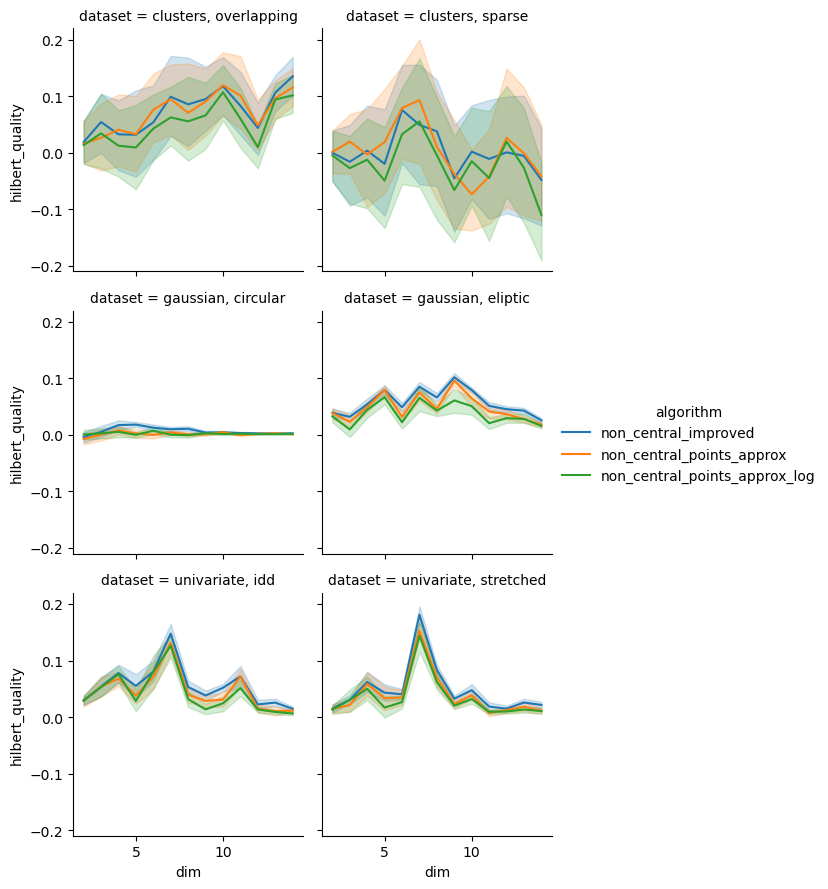

In [28]:
g = sns.FacetGrid(normalized_res[normalized_res.algorithm.isin(["non_central_improved","non_central_points_approx", "non_central_points_approx_log"])]
                  , col="dataset", hue="algorithm", col_wrap=2,
                 )
g.map(sns.lineplot, "dim", "hilbert_quality",errorbar="ci")#.set(ylim=(-0.2,1.1))
g.add_legend()
g.savefig("fig/hilbert_quality_200.svg")

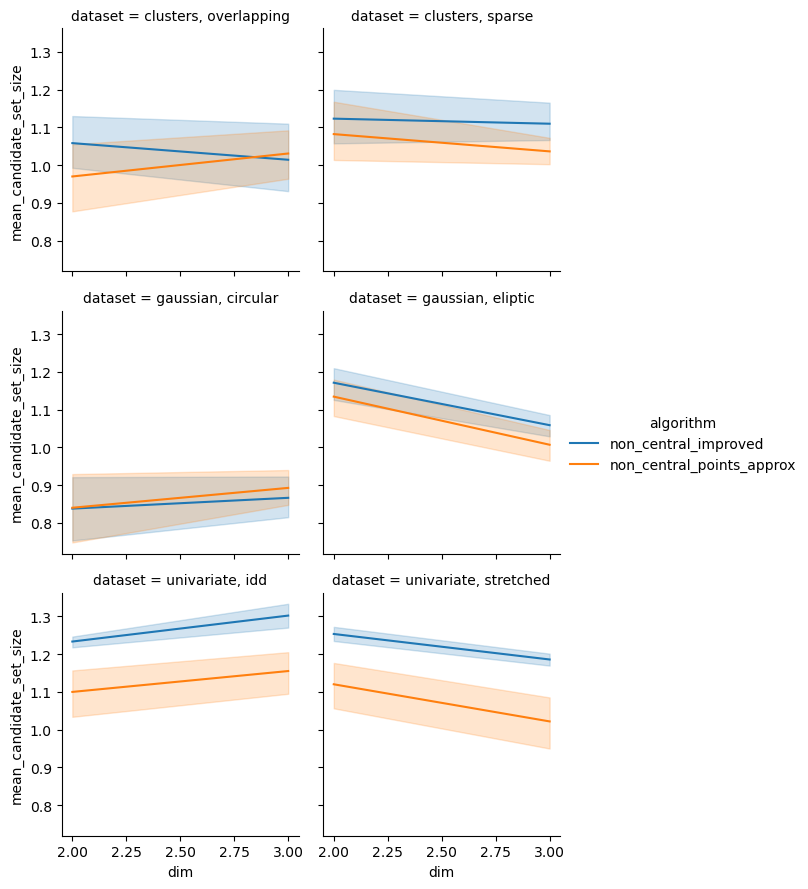

In [16]:
g = sns.FacetGrid(normalized_res[normalized_res.algorithm.isin(["non_central_improved","non_central_points_approx"])]
                  , col="dataset", hue="algorithm", col_wrap=2)
g.map(sns.lineplot, "dim", "mean_candidate_set_size")
g.add_legend()
g.savefig("fig/candidate_set_size_200.svg")

In [ ]:
    maximize_dist=max_dist_points,
    non_central_points=two_least_central,
    non_central_improved=low_centrality_and_far_away,
    non_central_points_approx=two_least_central_heuristically,
    non_central_points_approx_log=lambda *args,**kwargs:two_least_central_heuristically(
        *args,**kwargs, budget=lambda x:np.log(x)),

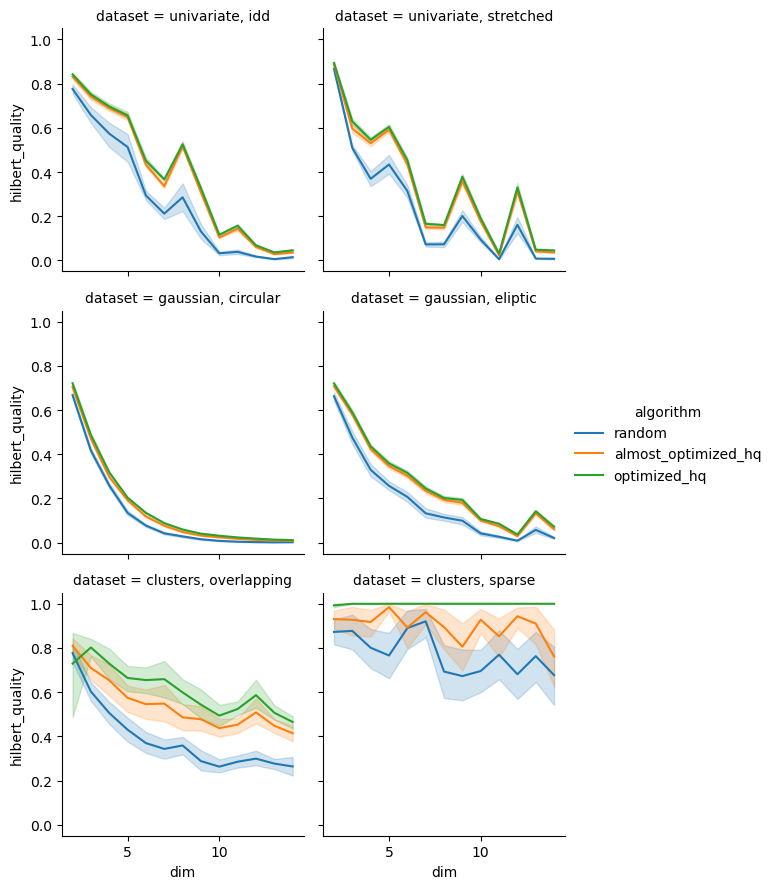

In [21]:
g = sns.FacetGrid(results, col="dataset", hue="algorithm", col_wrap=2,
                 )
g.map(sns.lineplot, "dim", "hilbert_quality",errorbar="ci")#.set(ylim=(-0.2,1.1))
g.add_legend()
g.savefig("fig/hilbert_quality_200.svg")

In [22]:
results.to_csv("optimized-comparison.csv")

In [18]:
dims = range(2,15)
sampels = range(16)

test_algs = dict(
    random=random_pivots,
    almost_optimized_hq=hilbert_almost_optimal,
    optimized_hq=hilbert_optimal_pivots,    
)

def run(run_id):
    r = compare_projections(generators, test_algs, dims, seed=100+run_id, errors="skip")
    r["run"] = run_id
    return r

jobs = [delayed(run)(run_id) for run_id in sampels]
results = pd.concat(Parallel(n_jobs=16, verbose=11)(jobs))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed: 41.9min
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed: 42.1min remaining: 182.4min
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed: 42.1min remaining: 92.7min
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed: 42.2min remaining: 54.3min
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed: 42.3min remaining: 32.9min
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed: 42.3min remaining: 19.2min
[Parallel(n_jobs=16)]: Done  13 out of  16 | elapsed: 42.3min remaining:  9.8min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed: 42.3min finished


  0%|          | 0/300 [00:00<?, ?it/s]


In [ ]:
def plot_hilbert_qual(ps):
    part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
    l, r = part.get_partitions(ps)

    plt.scatter(*ps.T)
    plt.scatter(*ps[l].T, marker="+", label="left partition")
    plt.scatter(*ps[r].T, marker="x", label="right partition")
    
    hq = part.hyperplane_quality(ps)
    css = proj_quality.candidate_set_size(ps,ten_nn_dist, Euclid(2))
    plt.title(f"partitioning {hq:.0%} points\nmean CSS {css:.0f}")
    plt.legend()
    plt.tight_layout()

In [ ]:
plt.subplot(2,2,1)
plot_hilbert_qual(points_p)
plt.subplot(2,2,2)
plot_hilbert_qual(points_p_max_dist)
plt.subplot(2,2,3)
plot_hilbert_qual(points_p_min_dist)